# AutoML for Images

### Parkinson Detection image classification with Azure ML and AutoML for Images (Image Classification Task)

We will build a computer vision model to detect parkinson symptom from drawings. A test that involves drawing a spiral on a sheet of paper could be used to diagnose early Parkinson's disease.

https://pubmed.ncbi.nlm.nih.gov/18074362/

<img src="https://ichef.bbci.co.uk/news/976/cpsprodpb/CDA9/production/_97694625_participantdrawing_5000px_300dpi-5of5.jpg" width=600>

## Setup
> To use this notebook, **you will need to install the private preview package for AutoML for Images from the private index**.

In [1]:
#!pip install --upgrade "azureml-train-core<0.1.1" "azureml-train-automl<0.1.1" "azureml-contrib-dataset<0.1.1" --extra-index-url "https://azuremlsdktestpypi.azureedge.net/automl_for_images_private_preview/"

In [2]:
#!pip install basic-image-eda

## 1. Informations

In [3]:
import json
import os
import urllib
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import cv2
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import urllib.request
from zipfile import ZipFile
import glob

In [4]:
import sys
print("Python version =", sys.version)

Python version = 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [5]:
import datetime
now = datetime.datetime.now()
print("Today =", now)

Today = 2021-10-05 10:31:13.597086


In [6]:
import azureml.core
print("You are using Azure ML version", azureml.core.VERSION)

You are using Azure ML version 0.1.0.36994775


In [7]:
# Your local platform
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platform']=platform.system()
        info['Platform-release']=platform.release()
        info['Platform-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processor']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platform': 'Linux',
 'Platform-release': '5.4.0-1055-azure',
 'Platform-version': '#57~18.04.1-Ubuntu SMP Fri Jul 16 19:40:19 UTC 2021',
 'Architecture': 'x86_64',
 'Hostname': 'seretkow8',
 'IP-address': '127.0.0.1',
 'MAC-address': '3f:ab:74:ea:f2:65',
 'Processor': 'x86_64',
 'RAM': '27 Go'}

## 2. Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

> Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [8]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [9]:
ws.name, ws.resource_group

('azuremlvision', 'azuremlvision-rg')

## 3. Azure ML GPU Compute target setup
**You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training.** <br><br>
**AutoML models for image tasks require GPU SKUs and support NC and ND families.** We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [10]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "automlgpu"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', #GPU cluster
                                                           idle_seconds_before_scaledown=1800, #Time out
                                                           min_nodes=0, 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [11]:
# Compute status
compute_target.provisioning_state

'Succeeded'

In [12]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 1,
 'targetNodeCount': 1,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 1,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2021-10-05T10:16:20.286000+00:00',
 'errors': None,
 'creationTime': '2021-10-05T10:04:37.864812+00:00',
 'modifiedTime': '2021-10-05T10:05:03.627241+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 4,
  'nodeIdleTimeBeforeScaleDown': 'PT1800S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_NC6'}

In [13]:
# Compute VM size
compute_target.vm_size

'STANDARD_NC6'

## 4. Experiment Setup
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) in your workspace to track your model training runs

In [14]:
from azureml.core import Experiment

experiment_name = 'AutomlImages-Parkinson' # Name of your experimentation
experiment = Experiment(ws, name=experiment_name)

In [15]:
experiment

Name,Workspace,Report Page,Docs Page
AutomlImages-Parkinson,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


## 5. Dataset with input Training Data
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

In [16]:
curdir = os.getcwd()
curdir

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/AutoMLforImages/parkinson'

In [17]:
os.mkdir('ImagesParkinson')
os.chdir('ImagesParkinson')

In [18]:
download_url='https://github.com/retkowsky/AutoMLforImages/blob/main/images/parkinson.zip?raw=true'
zip_file='parkinson.zip'
urllib.request.urlretrieve(download_url,filename=zip_file)

# Unzip files
with ZipFile(zip_file, 'r') as zip:
    print('>> Unzip the zip file...')
    zip.extractall()
    print('Done!')
    
# Delete the downloaded zip file
print("\n>> Deleting the zip file...")
os.remove(zip_file)
print("Done!")

>> Unzip the zip file...
Done!

>> Deleting the zip file...
Done!


In [19]:
print(os.listdir('.'))

['Testing', 'Training']



found 94 images.
Using 4 threads. (max:4)



100%|██████████| 94/94 [00:00<00:00, 105.27it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  94

dtype                                    |  uint8
channels                                 |  [3, 4]
extensions                               |  ['png']

min height                               |  251
max height                               |  256
mean height                              |  255.90425531914894
median height                            |  256

min width                                |  253
max width                                |  260
mean width                               |  255.9787234042553
median width                             |  256

mean height/width ratio                  |  0.9997090848641011
median height/width ratio                |  1.0
recommended input size(by mean)          |  [256 256] (h x w, multiples of 8)
recommended input size(by mean)          |  [256 256] (h x w, multiples of 16)
recommended input size(by

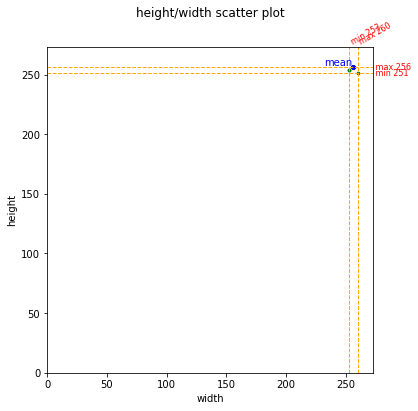

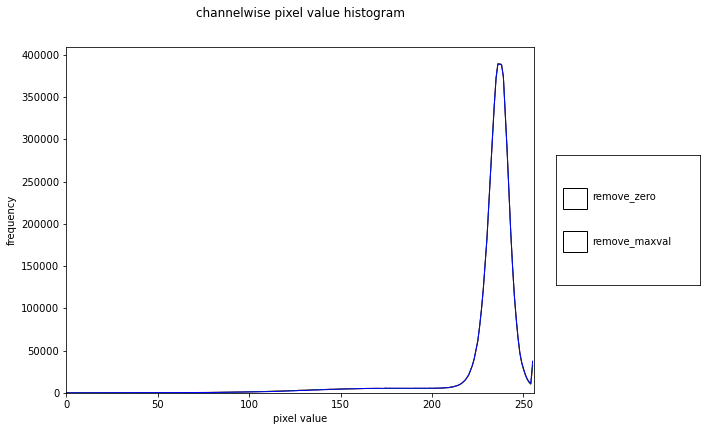

In [20]:
from basic_image_eda import BasicImageEDA

if __name__ == "__main__":  # for multiprocessing
    data_dir = "Training"
    
    extensions = ['png', 'jpg', 'jpeg']
    threads = 0
    dimension_plot = True
    channel_hist = True
    nonzero = False
    hw_division_factor = 1.0

    BasicImageEDA.explore(data_dir, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

In [21]:
for root, _, files in os.walk('.'):
    print("Dir:", root, "with", len(files), "images files.")

Dir: . with 0 images files.
Dir: ./Testing with 8 images files.
Dir: ./Training with 0 images files.
Dir: ./Training/healthy with 47 images files.
Dir: ./Training/parkinson with 47 images files.


### Some samples:

### Healthy

In [167]:
def imageview(filename):
    imgdisplay = cv2.imread(filename)
    print('Image:', filename, 'Image Size:', imgdisplay.shape)
    plt.figure(figsize=(5, 5)) 
    image_rgb2 = cv2.cvtColor(imgdisplay, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb2)

### Let's display 5 images

Image: Training/healthy/healthy (1).png Image Size: (256, 256, 3)
Image: Training/healthy/healthy (48).png Image Size: (254, 253, 3)
Image: Training/healthy/healthy (49).png Image Size: (256, 256, 3)
Image: Training/healthy/healthy (50).png Image Size: (256, 256, 3)
Image: Training/healthy/healthy (51).png Image Size: (256, 256, 3)


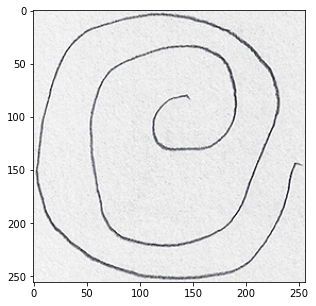

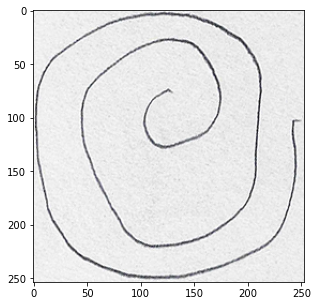

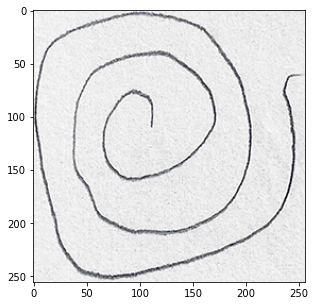

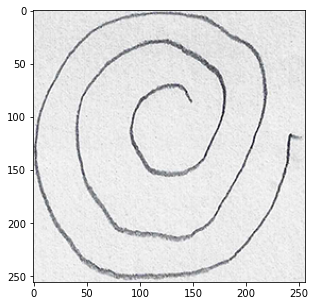

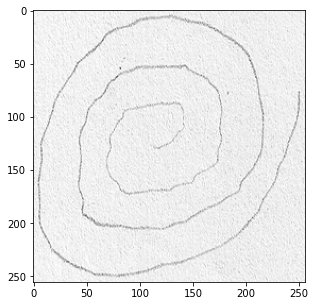

In [168]:
inputfolder="Training/healthy"
i=1
folderlen=len(inputfolder)
for img in glob.glob(inputfolder + "/*.png"):
    if i <=5:
        imageview(img)
        i+=1

### Parkinson

Image: Training/parkinson/parkinson (1).png Image Size: (256, 256, 3)
Image: Training/parkinson/parkinson (10).png Image Size: (256, 256, 3)
Image: Training/parkinson/parkinson (11).png Image Size: (256, 256, 3)
Image: Training/parkinson/parkinson (12).png Image Size: (256, 256, 3)
Image: Training/parkinson/parkinson (13).png Image Size: (256, 256, 3)


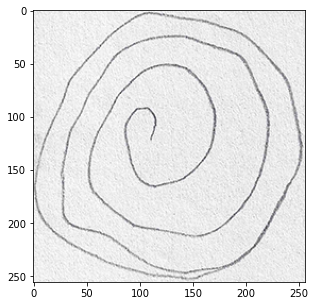

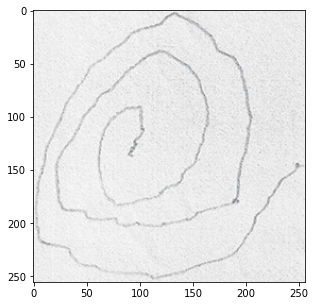

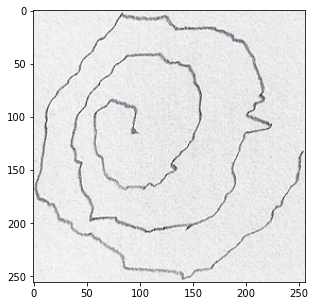

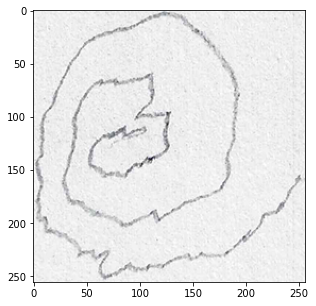

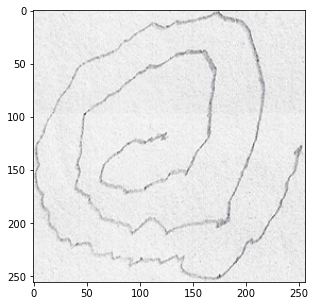

In [169]:
inputfolder="Training/parkinson"
i=1
folderlen=len(inputfolder)
for img in glob.glob(inputfolder + "/*.png"):
    if i <=5:
        imageview(img)
        i+=1

### Convert the downloaded data to JSONL


In [28]:
curdir = os.getcwd()
curdir

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/AutoMLforImages/parkinson/ImagesParkinson'

In [29]:
os.chdir("..")

In [31]:
src = "ImagesParkinson/Training/"

train_validation_ratio = 5

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the training and validation files
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")

# sample json line dictionary
json_line_sample = \
    {
        "image_url": "AmlDatastore://" + workspaceblobstore + "/"
                     + os.path.basename(os.path.dirname(src)),
        "label": "",
        "label_confidence": 1.0
    }

index = 0
# Scan each sub directary and generate jsonl line
with open(train_annotations_file, 'w') as train_f:
    with open(validation_annotations_file, 'w') as validation_f:
        for className in os.listdir(src):
            subDir = src + className
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing ImagesParkinson/Training/healthy
Parsing ImagesParkinson/Training/parkinson


### Upload the JSONL file and images to Datastore  
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets. It is an abstraction over Azure Storage.



In [33]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir='./ImagesParkinson/Training/', target_path='ImagesParkinson/Training')

Uploading an estimated of 96 files
Uploading ./ImagesParkinson/Training/train_annotations.jsonl
Uploaded ./ImagesParkinson/Training/train_annotations.jsonl, 1 files out of an estimated total of 96
Uploading ./ImagesParkinson/Training/validation_annotations.jsonl
Uploaded ./ImagesParkinson/Training/validation_annotations.jsonl, 2 files out of an estimated total of 96
Uploading ./ImagesParkinson/Training/healthy/healthy (1).png
Uploaded ./ImagesParkinson/Training/healthy/healthy (1).png, 3 files out of an estimated total of 96
Uploading ./ImagesParkinson/Training/healthy/healthy (48).png
Uploaded ./ImagesParkinson/Training/healthy/healthy (48).png, 4 files out of an estimated total of 96
Uploading ./ImagesParkinson/Training/healthy/healthy (49).png
Uploaded ./ImagesParkinson/Training/healthy/healthy (49).png, 5 files out of an estimated total of 96
Uploading ./ImagesParkinson/Training/healthy/healthy (50).png
Uploaded ./ImagesParkinson/Training/healthy/healthy (50).png, 6 files out of an

$AZUREML_DATAREFERENCE_42cc70ef8fce4589aad9a9c29b58a046

Finally, we need to create an Azure ML [Dataset](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [34]:
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask
from azureml.core import Dataset

training_dataset_name = 'ParkinsonTrainingDataset'
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print('Found the training dataset', training_dataset_name)
else:
    # create training dataset
    training_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('ImagesParkinson/Training/train_annotations.jsonl'))
    training_dataset = training_dataset.register(workspace=ws, name=training_dataset_name)
    
# create validation dataset
validation_dataset_name = "ParkinsonValidationDataset"
if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print('Found the validation dataset', validation_dataset_name)
else:
    validation_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('ImagesParkinson/Training/validation_annotations.jsonl'))
    validation_dataset = validation_dataset.register(workspace=ws, name=validation_dataset_name)

print()
print("Training dataset name:" + training_dataset.name)
print("Validation dataset name:" + validation_dataset.name)


Training dataset name:ParkinsonTrainingDataset
Validation dataset name:ParkinsonValidationDataset


Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the documentation for more details.

This is what the training dataset looks like

In [35]:
df=training_dataset.to_pandas_dataframe()

In [36]:
df.shape

(75, 3)

In [37]:
df.dtypes

image_url            object
label                object
label_confidence    float64
dtype: object

In [38]:
df.head()

,image_url,label,label_confidence
0,StreamInfo(AmlDatastore://Training/healthy/hea...,healthy,1.0
1,StreamInfo(AmlDatastore://Training/healthy/hea...,healthy,1.0
2,StreamInfo(AmlDatastore://Training/healthy/hea...,healthy,1.0
3,StreamInfo(AmlDatastore://Training/healthy/hea...,healthy,1.0
4,StreamInfo(AmlDatastore://Training/healthy/hea...,healthy,1.0


In [39]:
# Counts images by labels
df['label'].value_counts()

parkinson    38
healthy      37
Name: label, dtype: int64

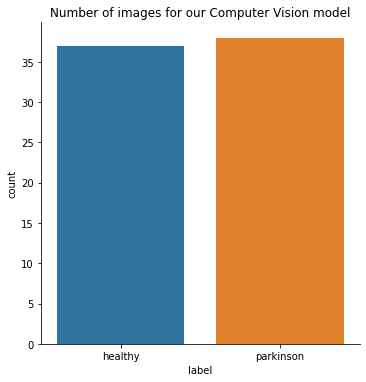

In [40]:
# Distribution
sns.catplot(x="label", kind="count", data=df, height=5).set(title='Number of images for our Computer Vision model')

In [41]:
# Percentage values
df['label'].value_counts(normalize=True)

parkinson    0.506667
healthy      0.493333
Name: label, dtype: float64

## 6. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the 'AutoMLImageConfig' - please refer to the [documentation](https://github.com/swatig007/automlForImages#readme) for the details on the parameters that can be used and their values. 

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple ones.<br><br> **Currently supported model algorithms for image classification: 'resnet18', 'resnet34', 'resnet50', 'mobilenetv2', 'seresnext'.**

### Using default hyperparameter values for the specified algorithm

Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This is for employing a more iterative approach, because with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially and you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say **resnet50**), you can specify the config for your AutoML Image runs as follows:

In [42]:
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import RandomParameterSampling
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice

In [43]:
# AutoML Configuration
image_config_resnet50 = AutoMLImageConfig(task='image-classification', # AutoML Vision task
                                          compute_target=compute_target, # Compute target
                                          training_data=training_dataset, # Training dataset
                                          validation_data=validation_dataset, # Validation dataset
                                          hyperparameter_sampling=GridParameterSampling({'model_name': 
                                                                                        choice('resnet50')})) # CV Model

## 7. Submitting an AutoML run for Computer Vision tasks 
Once you've created the config settings for your run, **you can submit an AutoML run** using the config in order to train a vision model using your training dataset.

In [44]:
automl_image_run = experiment.submit(image_config_resnet50)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutomlImages-Parkinson,AutoML_763317f8-d4cf-4fb1-97fb-fc2327ccfbdc,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [45]:
automl_image_run.wait_for_completion(wait_post_processing=True) # Wait until automl run is finished

{'runId': 'AutoML_763317f8-d4cf-4fb1-97fb-fc2327ccfbdc',
 'target': 'automlgpu',
 'status': 'Completed',
 'startTimeUtc': '2021-10-05T10:34:28.136157Z',
 'endTimeUtc': '2021-10-05T10:37:09.056678Z',
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'automlgpu',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlImages-Parkinson","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"azuremlvision-rg","workspace_name":"azuremlvision","region":"westeurope","compute_target":"automlgpu","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":"accuracy","task_type":"image-clas

In [46]:
automl_image_run.id

'AutoML_763317f8-d4cf-4fb1-97fb-fc2327ccfbdc'

In [47]:
experiment

Name,Workspace,Report Page,Docs Page
AutomlImages-Parkinson,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


In [48]:
# List of all the AutoML for Images metrics values
automlvisionmetrics = automl_image_run.get_metrics()
automlvisionmetrics

{'f1_score_macro': [0.43452,
  0.34483,
  0.54762,
  0.34483,
  0.32143,
  0.34483,
  0.70769,
  0.70769,
  0.66071,
  0.84034,
  0.84211,
  0.78889,
  0.73389,
  0.73389,
  0.73389],
 'precision_score_binary': [0.4,
  0.0,
  0.6,
  0.0,
  0.47368,
  0.0,
  1.0,
  1.0,
  0.8,
  0.875,
  0.8,
  0.72727,
  0.66667,
  0.66667,
  0.66667],
 'f1_score_micro': [0.47368,
  0.52632,
  0.57895,
  0.52632,
  0.47368,
  0.52632,
  0.73684,
  0.73684,
  0.68421,
  0.84211,
  0.84211,
  0.78947,
  0.73684,
  0.73684,
  0.73684],
 'AUC_weighted': [0.31111,
  0.4,
  0.48889,
  0.53333,
  0.72222,
  0.68889,
  0.75556,
  0.81111,
  0.81111,
  0.84444,
  0.88889,
  0.88889,
  0.91111,
  0.92222,
  0.92222],
 'precision_score_weighted': [0.45263,
  0.27701,
  0.58496,
  0.27701,
  0.22438,
  0.27701,
  0.82456,
  0.82456,
  0.71729,
  0.8451,
  0.84678,
  0.80502,
  0.76692,
  0.76692,
  0.76692],
 'average_precision_score_weighted': [0.45652,
  0.5175,
  0.56509,
  0.62609,
  0.7498,
  0.71331,
  0.755

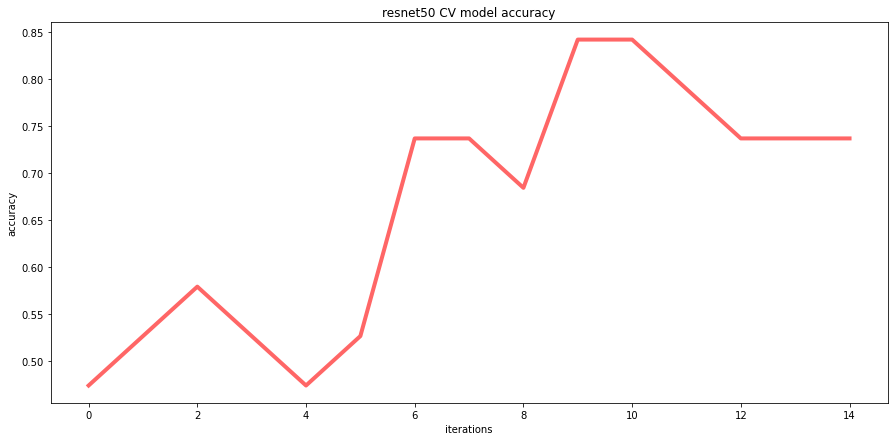

In [49]:
# Let's plot the accuracy metric for the CV model, save the graph to a jpg file and log it to the Azure ML experiment
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))
plt.plot(automlvisionmetrics['accuracy'], 'r-', lw=4, alpha=.6)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('resnet50 CV model accuracy', fontsize=12)
plt.savefig('accuracy_resnet50.jpg', dpi=150) # Saving image in a jpg file
automl_image_run.log_image(name='accuracy_resnet50.jpg', plot=plt) # Logging the graph into the Azure ML experiment
plt.show()

In [50]:
# Checking the output graph
!ls accuracy_resnet50.jpg -l

-rwxrwxrwx 1 root root 107499 Oct  5 10:37 accuracy_resnet50.jpg


In [51]:
# You can view the jpg file in the experiment
experiment

Name,Workspace,Report Page,Docs Page
AutomlImages-Parkinson,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


### Let's try additional models

In [52]:
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, RandomParameterSampling, BayesianParameterSampling
from azureml.train.hyperdrive import BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    'model': choice(
        {
            'model_name': choice('seresnext'),
            'learning_rate': uniform(0.0001, 0.01),
            'optimizer': choice('sgd', 'adam'),
            'layers_to_freeze': choice(1, 2, 3, 4),

        },
        {
            'model_name': choice('resnet50'),
            'resize_size': choice(128, 256), # model-specific
            #'crop_size': choice(224, 256), # model-specific, crop_size should be smaller or equal than resize_size
        },
        
        {
            'model_name': choice('mobilenetv2'),
            'learning_rate': uniform(0.0001, 0.01),
            'optimizer': choice('sgd', 'adam'),
            'layers_to_freeze': choice(0, 2, 4),

        },
        
          {
            'model_name': choice('resnet34'),
            'learning_rate': uniform(0.0001, 0.01),
            'layers_to_freeze': choice(1, 2, 4),
        },
        {
            'model_name': choice('resnet18'),
            'learning_rate': uniform(0.0001, 0.01),
            'layers_to_freeze': choice(1, 2, 4),
        },
        {
            'model_name': choice('resnet50'),
            'learning_rate': uniform(0.0001, 0.01),
            'layers_to_freeze': choice(1, 2, 4),
        },
    )
}

tuning_settings = {
    'iterations': 20, 
    'max_concurrent_iterations': 4, 
    'hyperparameter_sampling': RandomParameterSampling(parameter_space),  
    'policy': BanditPolicy(evaluation_interval=2, slack_factor=0.2, delay_evaluation=6)
}

automl_image_config = AutoMLImageConfig(task='image-classification',
                                        compute_target=compute_target,
                                        training_data=training_dataset,
                                        validation_data=validation_dataset,
                                        primary_metric='accuracy',
                                        **tuning_settings)

In [53]:
automl_image_run = experiment.submit(automl_image_config)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutomlImages-Parkinson,AutoML_d62202f3-4351-41af-82fa-dd6d63acb552,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [54]:
automl_image_run.wait_for_completion(wait_post_processing=True) # Wait until automl run is finished

{'runId': 'AutoML_d62202f3-4351-41af-82fa-dd6d63acb552',
 'target': 'automlgpu',
 'status': 'Completed',
 'startTimeUtc': '2021-10-05T10:38:24.181583Z',
 'endTimeUtc': '2021-10-05T10:53:53.457994Z',
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'automlgpu',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlImages-Parkinson","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"azuremlvision-rg","workspace_name":"azuremlvision","region":"westeurope","compute_target":"automlgpu","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":"accuracy","task_type":"image-clas

In [55]:
automl_image_run.id

'AutoML_d62202f3-4351-41af-82fa-dd6d63acb552'

In [56]:
automlvisionmetrics2 = automl_image_run.get_metrics()
automlvisionmetrics2

{'log_loss': [0.86431,
  0.63019,
  0.61221,
  0.72615,
  0.66849,
  0.66659,
  0.55323,
  0.45584,
  0.392,
  0.32462,
  0.29444,
  0.28342,
  0.28273,
  0.28005,
  0.27604],
 'f1_score_micro': [0.52632,
  0.68421,
  0.57895,
  0.57895,
  0.57895,
  0.68421,
  0.68421,
  0.68421,
  0.73684,
  0.94737,
  0.94737,
  0.89474,
  0.89474,
  0.89474,
  0.89474],
 'recall_score_micro': [0.52632,
  0.68421,
  0.57895,
  0.57895,
  0.57895,
  0.68421,
  0.68421,
  0.68421,
  0.73684,
  0.94737,
  0.94737,
  0.89474,
  0.89474,
  0.89474,
  0.89474],
 'average_precision_score_weighted': [0.7676,
  0.8157,
  0.9027,
  0.93367,
  0.97016,
  0.98012,
  0.98012,
  0.98995,
  0.98995,
  0.98995,
  0.98995,
  0.98995,
  0.98995,
  0.98995,
  0.98995],
 'recall_score_macro': [0.5,
  0.68333,
  0.55556,
  0.55556,
  0.55556,
  0.66667,
  0.66667,
  0.66667,
  0.72222,
  0.94444,
  0.94444,
  0.89444,
  0.89444,
  0.89444,
  0.89444],
 'average_precision_score_micro': [0.65645,
  0.81392,
  0.77475,
  0

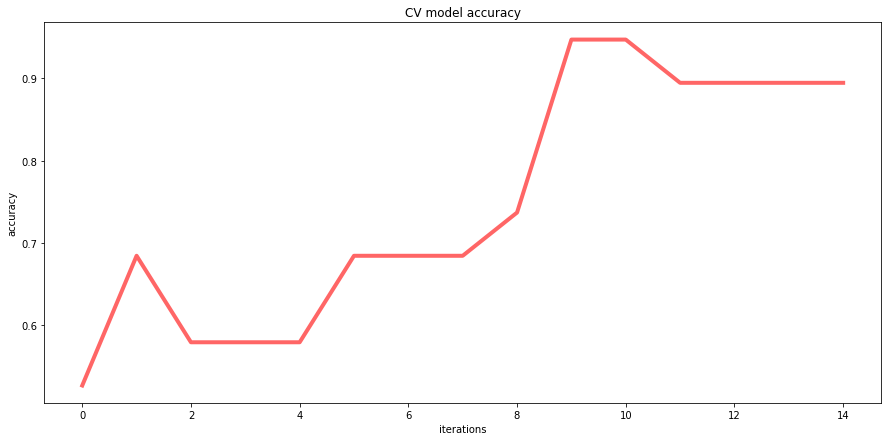

In [57]:
# Let's plot the accuracy metric for the CV model, save the graph to a jpg file and log it to the Azure ML experiment
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))
plt.plot(automlvisionmetrics2['accuracy'], 'r-', lw=4, alpha=.6)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('CV model accuracy', fontsize=12)
plt.savefig('accuracy.jpg', dpi=150) # Saving image in a jpg file
automl_image_run.log_image(name='accuracy.jpg', plot=plt) # Logging the graph into the Azure ML experiment
plt.show()

In [58]:
experiment

Name,Workspace,Report Page,Docs Page
AutomlImages-Parkinson,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


## 8. Register the optimal CV model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [59]:
from azureml.core import Run
hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + '_HD')
hyperdrive_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutomlImages-Parkinson,AutoML_d62202f3-4351-41af-82fa-dd6d63acb552_HD,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [60]:
# Defining tags for the custom vision model
cvmodel_tags={"Data": "Images", 
              "Context" : "Parkinson Detection",
              "Task" : "Best AutoML Images",
              "Framework" : "AzureML AutoML for Images",
              "AutoML Metric" : "Accuracy"}

In [61]:
# Register the best model from the AutoML Vision run
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']

model = best_child_run.register_model(model_name = model_name,
                                      model_path='outputs/model.pt',
                                      description='Parkinson Detection Classification CV model',
                                      tags=cvmodel_tags)

In [77]:
# We can download the CV model
model.download(target_dir='.', exist_ok=True)

'model.pt'

In [78]:
# Checking the downloaded .pt model file
!ls model.pt -l

-rwxrwxrwx 1 root root 89480908 Oct  5 12:09 model.pt


### Model informations from the Azure ML model repository

In [79]:
model

Model(workspace=Workspace.create(name='azuremlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='azuremlvision-rg'), name=AutoMLd62202f349, id=AutoMLd62202f349:1, version=1, tags={'Data': 'Images', 'Context': 'Parkinson Detection', 'Task': 'Best AutoML Images', 'Framework': 'AzureML AutoML for Images', 'AutoML Metric': 'Accuracy'}, properties={})

In [80]:
model.id

'AutoMLd62202f349:1'

In [81]:
model.name

'AutoMLd62202f349'

In [82]:
model.version

1

In [83]:
model.tags

{'Data': 'Images',
 'Context': 'Parkinson Detection',
 'Task': 'Best AutoML Images',
 'Framework': 'AzureML AutoML for Images',
 'AutoML Metric': 'Accuracy'}

In [84]:
model.created_time

datetime.datetime(2021, 10, 5, 11, 5, 19, 633368, tzinfo=<isodate.tzinfo.Utc object at 0x7f49dd89d390>)

## 9. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. **You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)).**<br><br> ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage. <br><br>
**In this tutorial, we will deploy the model as a web service in AKS.**
You will need to first create an AKS compute cluster, or use an existing AKS cluster. <br>
You can use either GPU or CPU VM SKUs for your deployment cluster

In [85]:
%%time
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "cluster-aks-cv"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6", 
                                                        location="westeurope")
    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws, 
                                      name=aks_name, 
                                      provisioning_configuration=prov_config)
    aks_target.wait_for_completion(show_output=True)

Found existing compute target.
CPU times: user 15.5 ms, sys: 8.03 ms, total: 23.5 ms
Wall time: 151 ms


Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.  
You can then deploy the model as an AKS web service.

In [86]:
# Settings

from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

best_child_run.download_file('outputs/scoring_file_v_1_0_0.py', output_file_path='score.py')
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script='score.py', environment=environment)

endpoint_name='automlparkinson' #Name of the deployed model

aks_tags={"Data": "Images", 
          "Topic" : "Parkinson Detection Custom Vision model", 
          "Task" : "Image Classification",
          "Framework" : "AutoML Images best model", 
          "AKS" : "True"}

aks_description="Computer vision model to identify Parkinson disease"

aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,                                                    
                                                cpu_cores=1,
                                                memory_gb=50,
                                                enable_app_insights=True,
                                                description=aks_description,
                                                tags=aks_tags)

In [88]:
# Checking the file we downloaded
!ls score.py -l

-rwxrwxrwx 1 root root 1953 Oct  5 12:09 score.py


In [89]:
best_child_run.download_file('train_artifacts/model.onnx', output_file_path='model.onnx')

In [90]:
# Checking the file we downloaded
!ls model.onnx -l

-rwxrwxrwx 1 root root 44695549 Oct  5 12:10 model.onnx


### Let's deploy the CV model into AKS

In [91]:
%%time
aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name=endpoint_name,
                           overwrite=True)

aks_service.wait_for_deployment(show_output=True)

print("\nDone. Model is deployed. Ready to use!")
print("\nAKS service status=", aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-10-05 12:12:00+00:00 Creating Container Registry if not exists.
2021-10-05 12:12:01+00:00 Registering the environment.
2021-10-05 12:12:02+00:00 Use the existing image.
2021-10-05 12:12:04+00:00 Creating resources in AKS.
2021-10-05 12:12:05+00:00 Submitting deployment to compute.
2021-10-05 12:12:05+00:00 Checking the status of deployment automlparkinson..
2021-10-05 12:12:29+00:00 Checking the status of inference endpoint automlparkinson.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Done. Model is deployed. Ready to use!

AKS service status= Healthy
CPU times: user 373 ms, sys: 170 ms, total: 544 ms
Wall time: 1min 10s


> Usually it takes 2 or 3 minutes to deploy. You can see the endpoint in Azure ML Studio

In [94]:
print("Computer Vision model endpoint:", aks_service.scoring_uri)
print("\nComputer Vision model endpoint properties:", aks_service.properties)
print("\nComputer Vision model endpoint tags:", aks_service.tags)

Computer Vision model endpoint: http://51.105.207.207:80/api/v1/service/automlparkinson/score

Computer Vision model endpoint properties: {'azureml.git.repository_uri': 'https://github.com/retkowsky/AutoMLforImages', 'mlflow.source.git.repoURL': 'https://github.com/retkowsky/AutoMLforImages', 'azureml.git.branch': 'main', 'mlflow.source.git.branch': 'main', 'azureml.git.commit': 'a987518ec8d17eb29d035a1bdaa5895246046dfb', 'mlflow.source.git.commit': 'a987518ec8d17eb29d035a1bdaa5895246046dfb', 'azureml.git.dirty': 'True', 'hasInferenceSchema': 'False', 'hasHttps': 'False'}

Computer Vision model endpoint tags: {'Data': 'Images', 'Topic': 'Parkinson Detection Custom Vision model', 'Task': 'Image Classification', 'Framework': 'AutoML Images best model', 'AKS': 'True'}


In [95]:
# You can have access to the logs
#print(aks_service.get_logs())

## 10. Test our deployed CV model
Finally, let's test our deployed Computer Vision model to predict new images. You can pass in any image.

In [96]:
print("Our Computer Vision model endpoint:", aks_service.scoring_uri)
print("\nStatus=", aks_service.state)

Our Computer Vision model endpoint: http://51.105.207.207:80/api/v1/service/automlparkinson/score

Status= Healthy


### Test 1

Let's download an image file to test:

In [97]:
cwd = os.getcwd()
cwd

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/AutoMLforImages/parkinson'

In [100]:
#image_url = ''
image_file = 'ImagesParkinson/Testing/testhealthy (1).png'
#urllib.request.urlretrieve(image_url, filename=image_file)

In [101]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: ImagesParkinson/Testing/testhealthy (1).png
- Image shape: (256, 256, 3)
- Image size: 196608


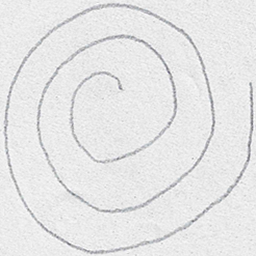

In [102]:
from IPython.display import Image
Image(filename=image_file)

In [103]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Status code= 200

Elapsed= 0:00:00.057482

Results= {"filename": "/tmp/tmpt1yh0nad", "probs": [0.9148235321044922, 0.08517642319202423], "labels": ["healthy", "parkinson"]}



In [104]:
prediction=pd.DataFrame(resp.json()) #Convert the Json into a pandas dataframe
pred=prediction.sort_values(by='probs', ascending=False)
pred.head(5)

,filename,probs,labels
0,/tmp/tmpt1yh0nad,0.914824,healthy
1,/tmp/tmpt1yh0nad,0.085176,parkinson


In [105]:
prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs']) # to take the max probability
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

print("Image file =", image_file)
print("Model prediction =", label, "\nwith Probability =", conf_score)
print()
print("\033[1;31;34mPrediction:\033[1;31;31m", label,"\033[1;31;34mwith a probability =", 
      round((conf_score*100), 2), "%")

Image file = ImagesParkinson/Testing/testhealthy (1).png
Model prediction = healthy 
with Probability = 0.9148235321044922

Prediction: healthy with a probability = 91.48 %


healthy (0.9148)


<Figure size 576x576 with 0 Axes>

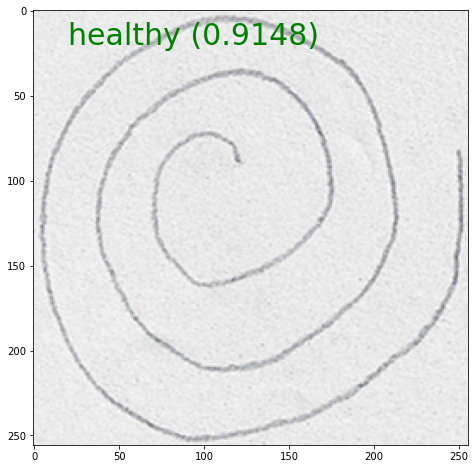

In [106]:
%matplotlib inline
from PIL import Image

IMAGE_SIZE = (8,8)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=IMAGE_SIZE)
# Display the image
ax.imshow(img_np)

prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs'])
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

display_text = '{} ({})'.format(label, round(conf_score, 4))
print(display_text)

if label=='healthy':
    color = 'green'

if label=='parkinson':
    color = 'red'

plt.text(20, 20, display_text, color=color, fontsize=30)
fig.savefig('predictiontest1.jpg', dpi=150) #Saving image
plt.show()

### Test 2

In [130]:
image_file = 'ImagesParkinson/Testing/testparkinson (4).png'

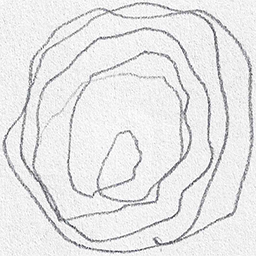

In [131]:
from IPython.display import Image
Image(filename=image_file)

In [132]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: ImagesParkinson/Testing/testparkinson (4).png
- Image shape: (256, 256, 3)
- Image size: 196608


In [133]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

# Load image data
data = open(image_file, 'rb').read()

# Set the content type
headers = {'Content-Type': 'application/octet-stream'}

# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Status code= 200

Elapsed= 0:00:00.048635

Results= {"filename": "/tmp/tmpeqg41a3v", "probs": [0.045381221920251846, 0.9546187520027161], "labels": ["healthy", "parkinson"]}



In [134]:
prediction=pd.DataFrame(resp.json()) #Convert the Json into a pandas dataframe
pred=prediction.sort_values(by='probs', ascending=False)
pred.head(5)

,filename,probs,labels
1,/tmp/tmpeqg41a3v,0.954619,parkinson
0,/tmp/tmpeqg41a3v,0.045381,healthy


In [135]:
prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs']) # to take the max probability
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

print("Image file =", image_file)
print("Model prediction =", label, "\nwith Probability =", conf_score)
print()
print("\033[1;31;34mPrediction:\033[1;31;31m", label,"\033[1;31;34mwith a probability =", 
      round((conf_score*100), 2), "%")

Image file = ImagesParkinson/Testing/testparkinson (4).png
Model prediction = parkinson 
with Probability = 0.9546187520027161

Prediction: parkinson with a probability = 95.46 %


parkinson (0.9546)


<Figure size 576x576 with 0 Axes>

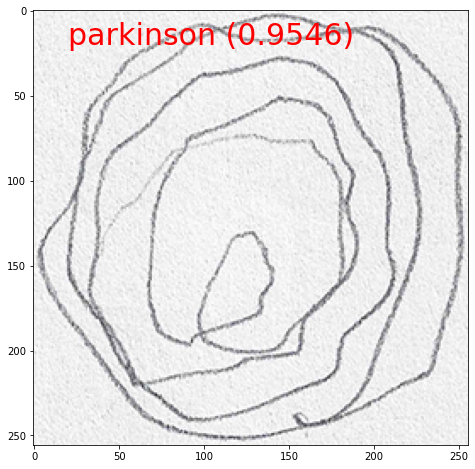

In [136]:
%matplotlib inline
from PIL import Image

IMAGE_SIZE = (8,8)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=IMAGE_SIZE)
# Display the image
ax.imshow(img_np)

prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs'])
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

display_text = '{} ({})'.format(label, round(conf_score, 4))
print(display_text)

if label=='healthy':
    color = 'green'

if label=='parkinson':
    color = 'red'

plt.text(20, 20, display_text, color=color, fontsize=30)
fig.savefig('predictiontest1.jpg', dpi=150) #Saving image
plt.show()

## 11. Clean up ressources

In [137]:
model.delete
aks_service.delete()
compute_target.delete()

> End of notebook